# Visualize Augmentations

In [1]:
import yaml
import json
import os
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import sys

parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)

from src.data.visualize import drawSegments
import src.data.augment as augment
import src.data.io as io

labels_dir = "segmentations"
data_path = "../data/Batsmen-Semantic-Segmentation[splitted]"
seg_names = os.listdir(f"{data_path}/segmentations/train")
img_names = os.listdir(f"{data_path}/images/train")
lbl_names = os.listdir(f"{data_path}/labels/train")
config_file_path = f"{data_path}/batsmen-semantic-segmentation.yaml"
class_names = []
with open(config_file_path) as handler:
    cnt = yaml.load(handler, Loader=yaml.FullLoader)
    class_names = cnt["names"]
human_names = ["Bowler", "Batsmen", "Wicket Keeper", "Umpire", "Fielder"]

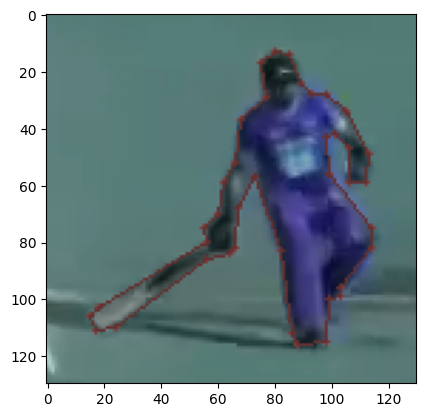

In [2]:
img_name = img_names[0]
txt_name = os.path.splitext(img_name)[0]+".txt"
txt_path = f"{data_path}/segmentations/train/{txt_name}"
img_path = f"{data_path}/images/train/{img_name}"
seg = ""
with open(txt_path) as handler:
    seg = handler.read()
img = cv.imread(img_path)
drawn_img = drawSegments(img, seg)
plt.imshow(drawn_img)
plt.show()

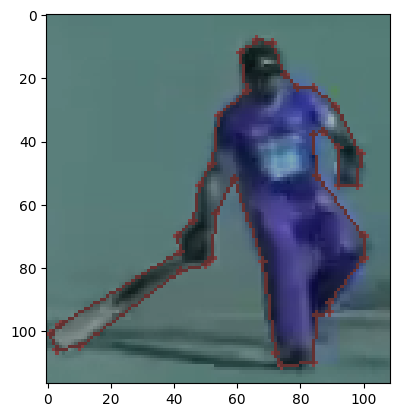

In [3]:
cropped_img, new_labels, crop_data = augment.DSSC(img, seg, label_type="segment")
drawn_img = drawSegments(cropped_img, new_labels)
plt.imshow(drawn_img)
plt.show()

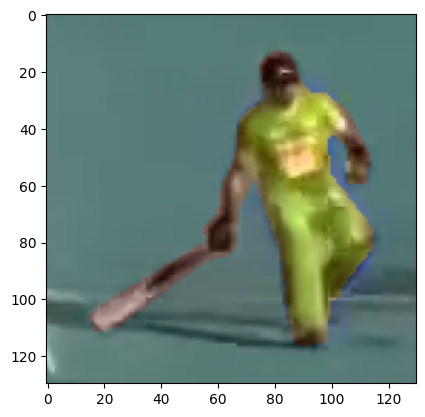

In [4]:
adjusted_img = augment.rotate_hue(img, seg, label_type="segment")
plt.imshow(adjusted_img)
plt.show()

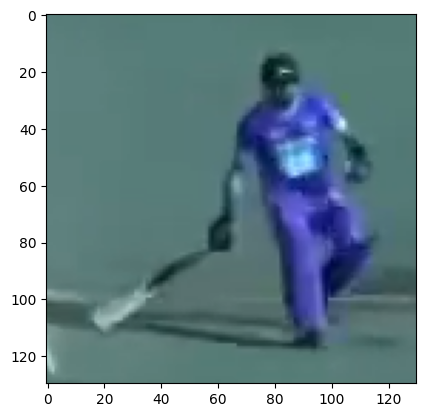

In [5]:
blur_img = augment.blur(img)
plt.imshow(blur_img)
plt.show()

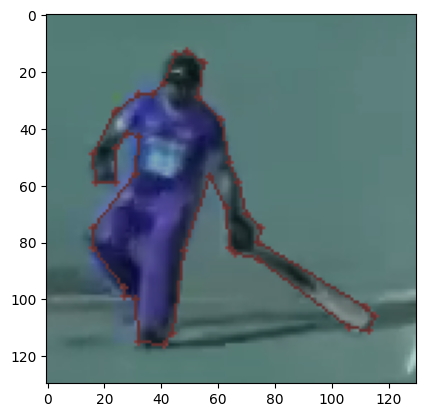

True


In [6]:
aug_img, lbls, flipped = augment.horizontal_flip(img, seg, label_type="segment")
drawn_aug_img = drawSegments(aug_img, lbls)
plt.imshow(drawn_aug_img)
plt.show()
print(flipped)

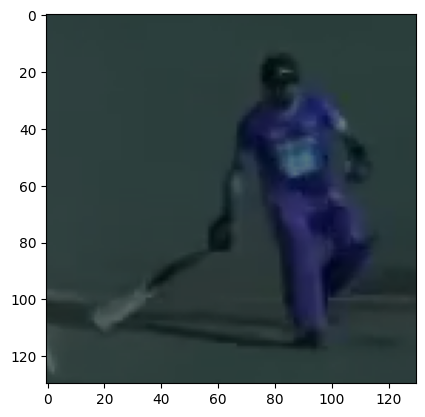

In [7]:
adjusted_img = augment.brightness_contrast(img)
plt.imshow(adjusted_img)
plt.show()

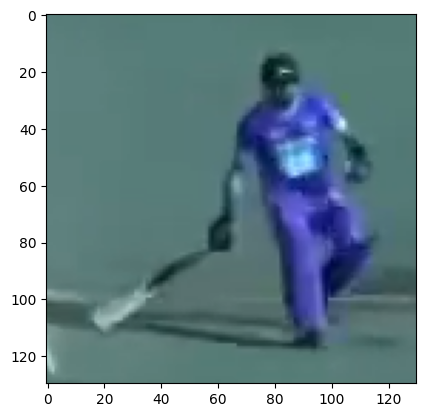

In [8]:
gn_img = augment.noise(img)
plt.imshow(gn_img)
plt.show()

# Create Dataset

In [9]:
# from google.colab import drive
# drive.mount("/content/drive")
# !rm -r sample_data
# !cp -r /content/drive/MyDrive/IIT-Projects/third-umpire-decision-automation/.creds/.aws ~/
# !cp -r /content/drive/MyDrive/IIT-Projects/third-umpire-decision-automation/backend/experiments/src ./

In [10]:
# !pip install -qq sagemaker

In [11]:
# from src.data.download import download
# from src.data.generate import segmentationDS2DetectionDS

# ds_path = download("cricket-semantic")
# segmentationDS2DetectionDS(ds_path)

In [12]:
# import os
# import sys

# parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
# sys.path.append(parent_dir)

# import src.data.augment as augment
# from src.data.process import splitDataset

In [13]:
# batsman_emphasis = [13,30,32,67,68,87,88,89,99,115,117,118,119,120,121,166,237,279,280,281,282,325,326,327,344]
# wicket_emphasis = [13,14,30,32,67,68,87,88,89,90,115,117,119,166,237,326,327,344]
# delete_nums = [236,328]
# emphasis_names = list(set(batsman_emphasis).union(set(wicket_emphasis)))
# total_raw_data_count = 298
# emphasis_weight = 10
# augment_rounds = 3

In [14]:
# original_data_path = "../data/Cricket-Semantic-Segmentation"
# augment_data_path = "../data/Cricket-Semantic-Segmentation-Augmented"

# augment.create_dataset(
#     original_data_path,
#     augment_data_path,
#     total_raw_data_count,
#     delete_nums,
#     emphasis_names,
#     augment_rounds,
#     emphasis_weight,
# )

In [15]:
# train_weight = 7
# val_weight = 2
# splited_augmented_path = f"{augment_data_path}[Splitted]"
# splitDataset(augment_data_path, train_weight, val_weight, splited_augmented_path)

In [16]:
# from sagemaker.s3 import S3Uploader
# s3_uri = "s3://third-umpire-decision-automation-osura/datasets/object-segment-augmented-dataset"
# S3Uploader.upload(splited_augmented_path, s3_uri)